[    0 0.sto3g.0.2023-04-29 09:37:04.txt     0] 93205.9854915142
[    0 1.sto3g.1.2023-04-29 09:37:04.txt     1] 6639.086841344833
[    0 2.sto3g.2.2023-04-29 09:37:04.txt     2] 81974.53034734726
[    0 3.sto3g.3.2023-04-29 09:37:04.txt     3] 59788.342277765274
[    0 5.sto3g.5.2023-04-29 09:37:04.txt     5] 43576.215992212296
[    0 7.sto3g.7.2023-04-29 09:37:04.txt     7] 86494.18042230606
[    0 9.sto3g.9.2023-04-29 09:37:04.txt     9] 101934.86452007294
[    0 10.sto3g.10.2023-04-29 09:37:04.txt    10] 100277.31315398216
[    0 11.sto3g.11.2023-04-29 09:37:04.txt    11] 67797.47506833076
[    0 12.sto3g.12.2023-04-29 09:37:04.txt    12] 103068.34550642967
[    0 14.sto3g.14.2023-04-29 09:37:04.txt    14] 79664.68042325974
[    0 15.sto3g.15.2023-04-29 09:37:04.txt    15] 65614.09661245346
[    1 1.sto3g.17.2023-04-29 09:37:04.txt    17] 103529.73809671402
[    1 2.sto3g.18.2023-04-29 09:37:04.txt    18] 57642.16479730606
[    1 7.sto3g.23.2023-04-29 09:37:04.txt    23] 3548.21148

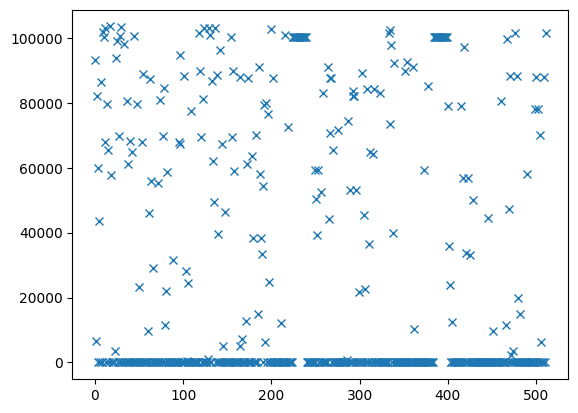

In [48]:
import os 
from natsort import natsorted 

a = natsorted([a for a in os.listdir("data/generated/bigrun5/") if "_" not in a])
import time 
# just find last time file was updated and get lc? 

ipu_num = 0
times = []

died = 0 

for folder in a: 
  files = natsorted(os.listdir("data/generated/bigrun5/%s/"%folder))
  for file in files[len(files)//16-1::len(files)//16]:  # how do I get the newest files here?
    t = os.path.getmtime("data/generated/bigrun5/%s/%s"%(folder, file) )
    if time.time()-t > 10: 
      print("[%5s %5s %5i]"%(folder, file, ipu_num), time.time()-t)
      died += 1
    times.append(time.time()-t)
    ipu_num+=1

import matplotlib.pyplot as plt 

plt.plot(times, 'x')



In [3]:
died

183

In [7]:
import os 
import pandas as pd 
from natsort import natsorted
from tqdm import tqdm

def load_run(run="run1"):
  folders = natsorted([a for a in os.listdir("data/generated/%s/"%run) if ".txt" not in a ])#[-8:]

  total = 0 

  df = []
  pbar = tqdm(folders)
  for folder in pbar:
    #print(folder)
    file = "data/generated/%s/%s/data.csv"%(run, folder)
    if os.path.isfile(file): 
      try: 
        df.append(pd.read_csv(file, compression="gzip"))
        total += df[-1].shape[0]
        pbar.set_description(str(df[-1].shape) + " " + str(total))
      except:
        pass 

  df = pd.concat(df)
  print(df.shape)
  return df 

df8 = load_run("bigrun5") # we do roughly 600k / hour of the larger ones, so in 12 hours we'll have ~ 10M?

(161873, 15) 156081844: 100%|██████████| 752/752 [2:05:05<00:00,  9.98s/it]  


(156081844, 15)


In [8]:
df8.shape

(156081844, 15)

In [12]:
pyscf = df8[df8["pyscf_hlgap"] != 0.0]

In [51]:
pyscf.to_parquet("dump_big5_4.30.2023_pyscfsubset.parquet")

In [13]:
pyscf.shape

(20476, 15)

20206
124
80
66
0.0002615236716418259
0.301523944387194
0.004940798527546655
0.6937906726513624
0.002099031796025912
0.00014660174694558492


Text(0.5, 0, 'convergence std [eV]')

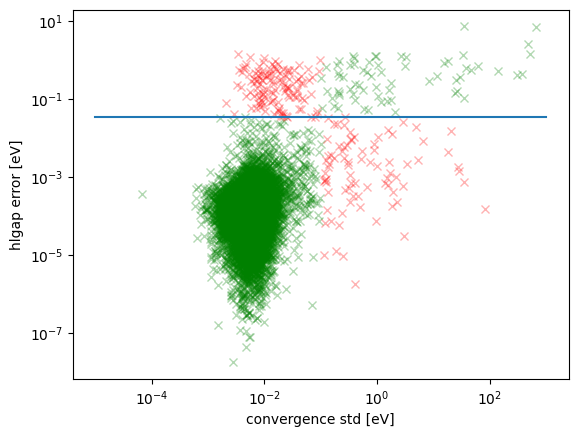

In [96]:
import matplotlib.pyplot as plt 
import numpy as np 

i     = 0
e     = np.concatenate([np.fromstring(pyscf["energies"].values[i][1:-1], sep=",", dtype=np.float64).reshape(1, -1) for i in range(pyscf.shape[0])], axis=0)
p     = [np.fromstring(pyscf["pyscf_energies"].values[i][1:-1], sep=",", dtype=np.float64) for i in range(pyscf.shape[0])]
std   = np.std(e[:, -5:], axis=1)

hlgap = np.abs(pyscf["hlgap"]- pyscf["pyscf_hlgap"])
plt.plot(std[np.logical_and(std<0.1, hlgap<0.034)], hlgap[np.logical_and(std<0.1, hlgap<0.034)], 'gx', alpha=0.3)
plt.plot(std[np.logical_and(std<0.1, hlgap>0.034)], hlgap[np.logical_and(std<0.1, hlgap>0.034)], 'rx', alpha=0.3)
plt.plot(std[np.logical_and(std>0.1, hlgap<0.034)], hlgap[np.logical_and(std>0.1, hlgap<0.034)], 'rx', alpha=0.3)
plt.plot(std[np.logical_and(std>0.1, hlgap>0.034)], hlgap[np.logical_and(std>0.1, hlgap>0.034)], 'gx', alpha=0.3)

print(np.sum(np.logical_and(std<0.1, hlgap<0.034))) # 20206 
print(np.sum(np.logical_and(std<0.1, hlgap>0.034))) # don't sort away 100/20000; how many percent is this?  0.6%; not too bad. 
print(np.sum(np.logical_and(std>0.1, hlgap<0.034))) # the ones we wrongly throw away; 80 
print(np.sum(np.logical_and(std>0.1, hlgap>0.034))) # the ones we correctly throw away. 

print(np.mean(hlgap[np.logical_and(std<0.1, hlgap<0.034)]))
print(np.mean(hlgap[np.logical_and(std<0.1, hlgap>0.034)]))
print(np.mean(hlgap[np.logical_and(std>0.1, hlgap<0.034)]))
print(np.mean(hlgap[np.logical_and(std>0.1, hlgap>0.034)]))
print(np.mean(hlgap[std<0.1]))# 0.002 MAE; still 10x better, but without the bad 100 ones it's 0.002, so they increase MAE by 10x! 
print(np.median(hlgap[std<0.1]))# 0.002 MAE; still 10x better, but without the bad 100 ones it's 0.002, so they increase MAE by 10x! 


# so can't do better than MSE 0.002 and MAE 0.00014



plt.plot([1e-5, 1e3], [0.034, 0.034])
plt.yscale("log")
plt.xscale("log")
plt.ylabel("hlgap error [eV]")
plt.xlabel("convergence std [eV]")

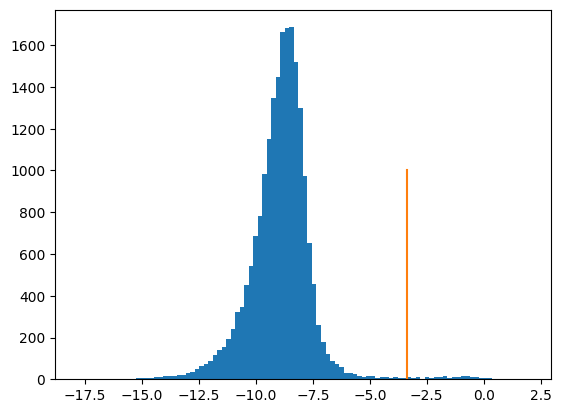

In [69]:
plt.hist(np.log(hlgap), bins=100)
plt.plot(np.log(np.array([0.034, 0.034])), [0, 1000])


In [40]:
#ads = np.flip(np.argsort(hlgap))
#errors = hlgap.values[ads]
#print(errors[:100])

[7.14174632 6.82682284 2.53518338 1.41089241 1.37102681 1.35258382
 1.26792009 1.24526706 1.2250836  1.22125871 1.20357429 1.19389211
 1.11558275 1.10746451 0.99060181 0.91107023 0.91060216 0.90176961
 0.87482242 0.86968289 0.81959021 0.78859363 0.76837392 0.76227294
 0.75563157 0.75247532 0.74074486 0.72775734 0.72702361 0.7087822
 0.7034918  0.69225621 0.6773919  0.6478003  0.63387234 0.59854235
 0.59679633 0.58818678 0.58376452 0.57968557 0.57347315 0.55252591
 0.55087096 0.54861881 0.54333352 0.5360274  0.53523434 0.51994671
 0.51853744 0.50399121 0.5033134  0.50096724 0.496719   0.48481982
 0.4797907  0.47931496 0.46689985 0.46669099 0.4649825  0.44490032
 0.443761   0.44133359 0.42837964 0.4207277  0.41730478 0.41447453
 0.40860057 0.40614012 0.39329075 0.38970864 0.38840666 0.38468155
 0.3838762  0.37376435 0.37093569 0.35587918 0.35277503 0.3342207
 0.32194138 0.32140531 0.31997855 0.31402387 0.31319972 0.30755477
 0.30585343 0.3050571  0.30264575 0.29919063 0.29414889 0.286427

In [93]:
indxs = np.flip(np.argsort(hlgap))

In [ ]:
# look at energy curve 

In [ ]:
# start cleaning code and juts be more and more sure about results? 

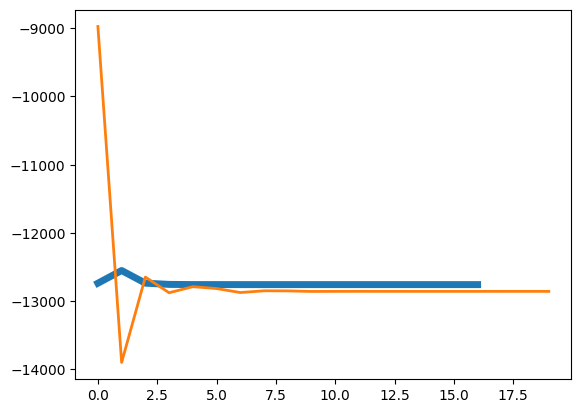

In [99]:
plt.plot(p[2], lw=5)
plt.plot(e[2], lw=2)